In [8]:
require 'nn'
require 'cunn'
require 'cutorch'
require 'lfs'

In [9]:
model = torch.load('SegNet_current_best_light_240x320.t7')

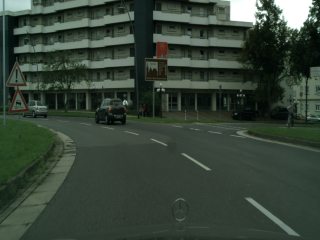

In [10]:
require 'image'

img = image.load('citiscapes/images/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png')
img_small = image.scale(img,"320x240")
itorch.image(img_small)

In [11]:
class_labels = {'Building','Road_marking','Fence','Bicyclist','Car','Void','Tree','TrafficLight','Sky','Pedestrian','Pole','Sidewalk','SignSymbol','Road'}
colors = {{128,0,0},{255,64,0},{64,64,128},{0,128,192},{64,0,128},{0,0,0},
          {128,128,0},{0,64,64},{128,128,128},{64,64,0},{192,192,128},{0,0,192},{192,128,128},{128,64,128}}
colors = torch.Tensor(colors)
for i=1,14 do print(class_labels[i], colors[i][1], colors[i][2], colors[i][3]) end

function classes_to_rgb(res)
    res = torch.squeeze(res):float()
    rgb = torch.Tensor(3,res:size(1),res:size(2))
    counter = 0
    start = sys.clock()
    for i=1,res:size(1) do
        for j=1,res:size(2) do
            rgb[{{},{i},{j}}] = colors[res[i][j]]
        end
    end
    print(sys.clock()-start)
    --print(rgb:size())
    return rgb
end

Building	128	0	0	
Road_marking	255	64	0	
Fence	64	64	128	
Bicyclist	0	128	192	
Car	64	0	128	
Void	0	0	0	
Tree	128	128	0	
TrafficLight	0	64	64	
Sky	128	128	128	
Pedestrian	64	64	0	
Pole	192	192	128	
Sidewalk	0	0	192	
SignSymbol	192	128	128	
Road	128	64	128	


forward: 	0.038096189498901	


0.41935515403748	


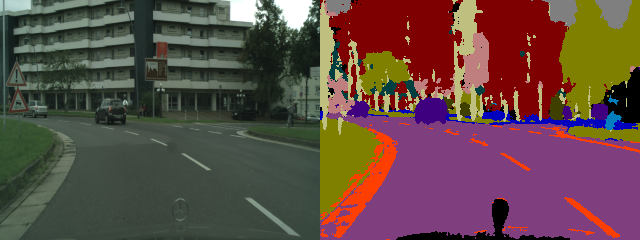

In [12]:
input = torch.CudaTensor(1,3,240,320) 
input[1] = img_small
start = sys.clock()
pred = model:forward(input)
print("forward: ",sys.clock()-start)
prob, classes = pred:sort(true)
res = torch.reshape(classes[{{},{1}}],1,240,320)
rgb_res = classes_to_rgb(res)
itorch.image(torch.cat(torch.squeeze(input):double(),rgb_res:div(256),3))

In [ ]:
get_path=function(str,sep)
    sep=sep or'/'
    return str:match("(.*"..sep..")")
end

images_path = 'citiscapes/images/'

function dirtree(dir)
  assert(dir and dir ~= "", "directory parameter is missing or empty")
  if string.sub(dir, -1) == "/" then
    dir=string.sub(dir, 1, -2)
  end

  local function yieldtree(dir)
    for entry in lfs.dir(dir) do
      if entry ~= "." and entry ~= ".." then
        entry=dir.."/"..entry
        local attr=lfs.attributes(entry)
        coroutine.yield(entry,attr)
        if attr.mode == "directory" then
          yieldtree(entry)
        end
      end
    end
  end

  return coroutine.wrap(function() yieldtree(dir) end)
end

In [ ]:
for filename, attr in dirtree(images_path) do
    if attr.mode == 'file' then
        img = image.load(filename)
        img_small = image.scale(img,"320x240")
        input = torch.CudaTensor(1,3,240,320) 
        input[1] = img_small
        pred = model:forward(input)
        prob, classes = pred:sort(true)
        res = torch.reshape(classes[{{},{1}}],1,240,320)
        rgb_res = classes_to_rgb(res)
        image.save(get_path(filename) .. 'seg_' .. filename.gsub(filename, get_path(filename), ''), rgb_res:div(256))
    end
end